In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
plt.rcParams['figure.figsize'] = (12,5)

In [ ]:
df = pd.read_csv('/content/11. Number of domestic air travel passengers.csv', index_col=0, parse_dates=True)

df.head()

,Number of domestic air passengers
Date,
2003-01-01,43032450
2003-02-01,41166780
2003-03-01,49992700
2003-04-01,47033260
2003-05-01,49152352


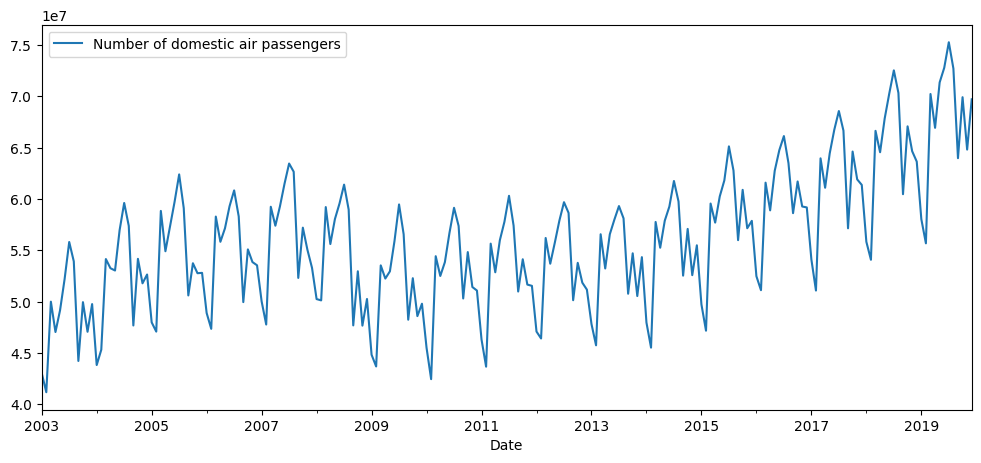

In [ ]:
df.plot()

plt.show()

По графику видно, что дисперсия в целом остается боле-менее стабильной; поэтому, преобразование Бокса-Кокса можно не делать. Кроме того, из предыдущего задания помним, что в ряде есть ярко выраженная сезонность (с периодом 12) и тренд; поэтому, чтобы ряд стал стационарным, следует произвести два последовательных дифференцирования

In [ ]:
y_transformation = pd.DataFrame(df['Number of domestic air passengers'].values, columns=['initial'])
y_transformation['seasonal_diff'] = y_transformation['initial'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [ ]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.982428
После сезонного дифференцирования: p=0.048057
После дополнительного дифференцирования: p=0.000665


Видим, что может быть достаточно и сезонного дифференцирования, однако значение p-уровня находится на грани критического; отдельно посмотрим на ряд, получающийся после сезонного дифференцирования

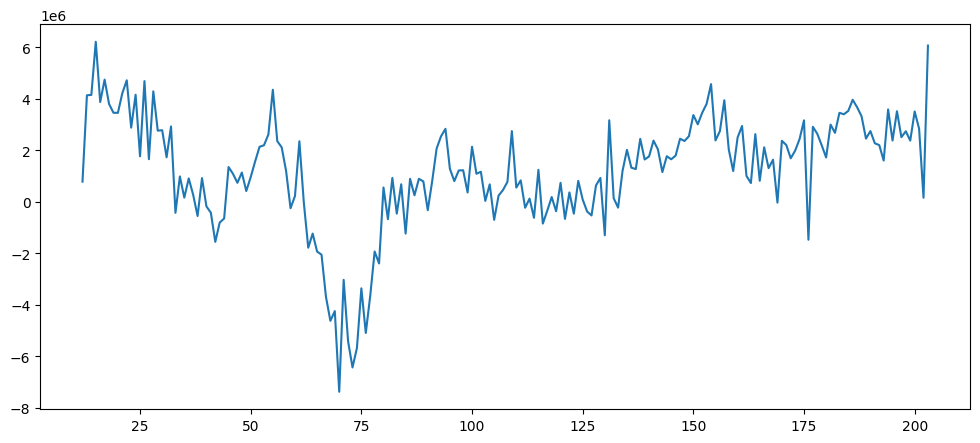

In [ ]:
plt.plot(y_transformation['seasonal_diff'])

plt.show()

На графике заметны серъезные отличия получающегося ряда от стационарного (сильно выделяется большой провал в начале). На контрасте отрисуем ряд после дополнительного диффернцирования.

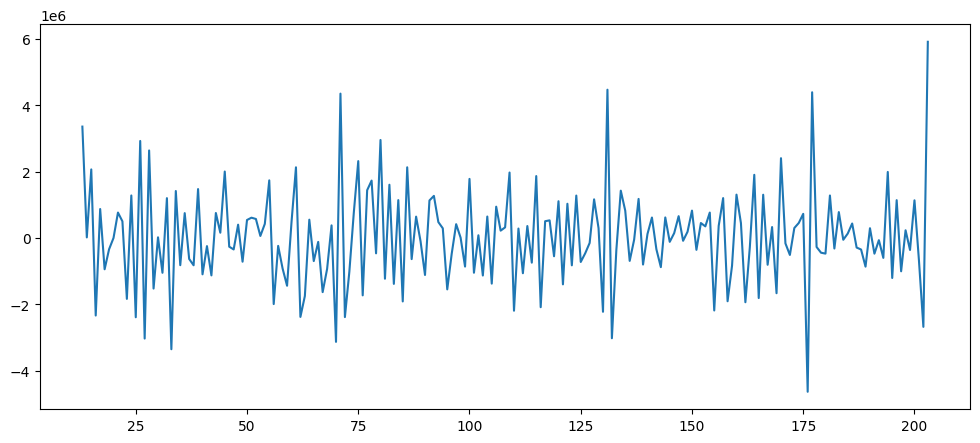

In [ ]:
plt.plot(y_transformation['lag1_diff'])

plt.show()

Легко увидеть, что такой ряд значительно ближе к стационарному; соответственно, целесообразнее будет использовать именно его

# Построение модели и прогноз

Для начала определим подходящие параметры p,q,P и Q в модели SARMA; построим диаграммы автокорреляции и частичной автокорреляции

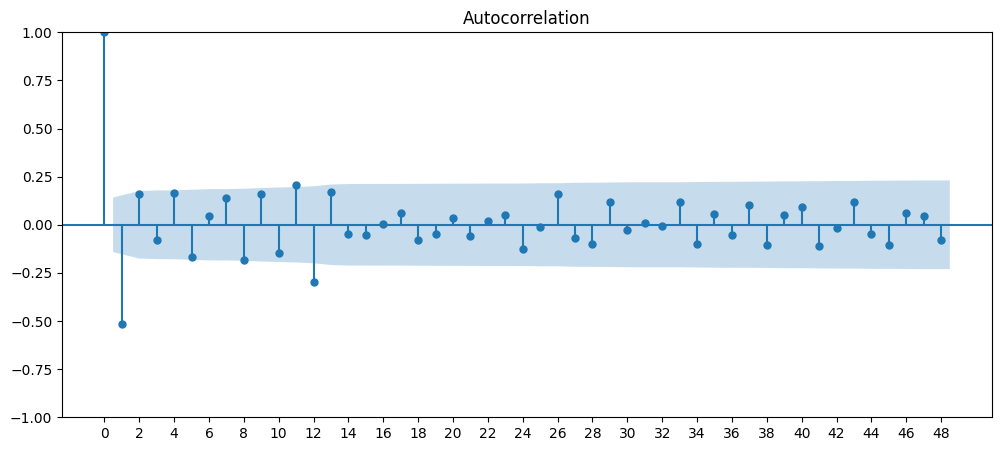

In [ ]:
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Видим, что последним значимым лагом для порядка авторегрессии является q = 1, а для скользящего среднего - так же Q = 1.

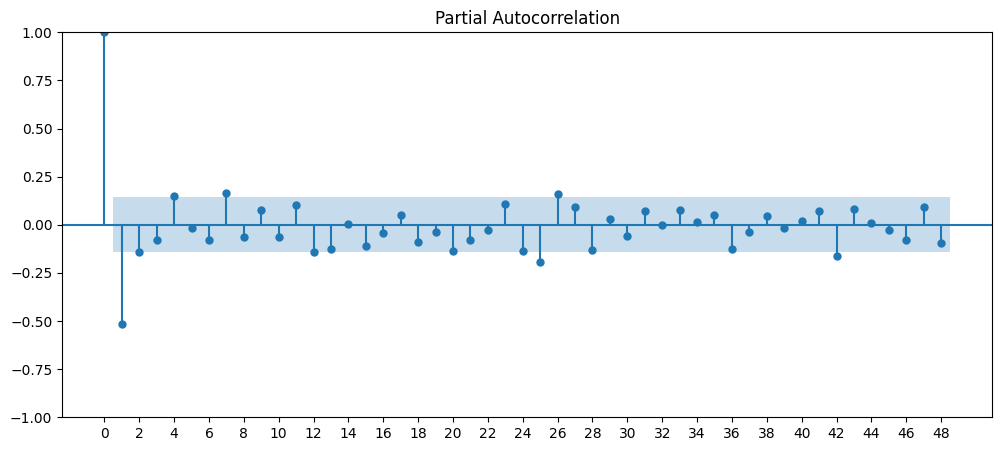

In [ ]:
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Из диаграммы автокорреляции получаем, что последний значимый лаг для  p=2, а для P=1 (с 24 не очень понятно, входит он в интервал или нет)

Далее, зададим сетку вокруг определенных выше значений и подберем оптимальные величины гиперпараметров (по критерию Акаики)

In [ ]:
# Сетка с небольшими отступами влево и вправо от оптимальных значений
p = range(0, 3)
q = range(0, 2)
P = range(0, 3)
Q = range(0, 2)

parameters = product(p, [1], q, P, [1], Q, [12])
parameters_list = list(parameters)

In [ ]:
best_res = (0, np.inf)

# Последовательный отбор наилучшего сочетания гиперпараметров
for params in parameters_list:
  l1 = params[:3]
  l2 = params[3:]

  model = SARIMAX(y_transformation['initial'],
                order=l1,
                seasonal_order=l2).fit()


  if best_res[1] > model.aic:
    best_res = (params, model.aic)

In [ ]:
best_res[0] # Выведем лучший набор гиперпараметров

(0, 1, 1, 1, 1, 1, 12)

Теперь, используя найденный оптимальный набор гиперпараметров, обучим модель SARIMA и сделаем прогноз на 3 года

In [ ]:
best_model = SARIMAX(y_transformation['initial'],
                     order=best_res[0][:3],
                     seasonal_order=best_res[0][3:]).fit()

best_model.params # Выведем полученные оценки параметров

ma.L1      -1.371270e-01
ar.S.L12    5.641133e-01
ma.S.L12   -7.017497e-01
sigma2      1.464934e+12
dtype: float64

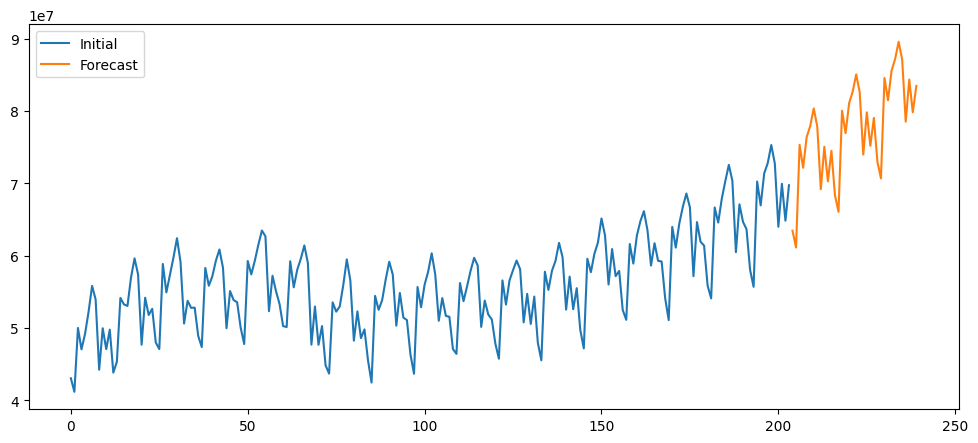

In [ ]:
y_transformation['initial'].plot()
best_model.forecast(36).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()